# Temporal Difference
Implement the basic TD learning algorithm (i.e. tabular TD(0)) to find a good path (given by a policy) for an agent exploring the environment from a starting point to a reward location in a simple environment.

Where **S** is the starting location and **E** the end location.

## Environment

In [10]:
import numpy as np
from collections import namedtuple

WORLD = np.array([
  [' ', ' ', ' ', ' ', ' ', ' ', ' '],
  [' ', 'W', 'W', 'W', 'W', ' ', ' '], 
  [' ', 'W', 'E', ' ', 'W', ' ', ' '],
  [' ', ' ', 'W', ' ', 'W', 'W', ' '],
  [' ', ' ', 'W', ' ', ' ', ' ', ' '],
  ['S', 'W', ' ', ' ', ' ', ' ', ' '],
 ])
world_height = WORLD.shape[0]
world_width = WORLD.shape[1]

State = namedtuple('State', 'row col')
initial_state = State(5, 0)

## Reward Signal

In [11]:
def reward(state):
    return 1.0 if WORLD[state.row, state.col] == 'E' else 0.0

reward(initial_state)

0.0

## Value Function

In [12]:
def zero_values():
    return np.zeros((WORLD.shape))

def value(state):
    return V[state.row, state.col]


def show_values(decimal_numbers=5):
    cell_value = "{" + ":.{}".format(decimal_numbers) + "f} " 
    for row in range(V.shape[0]):
        val = "" 
        for col in range(V.shape[1]):
          val += cell_value.format(V[row, col])
        print(val)
        
V = zero_values()
# print(value(initial_state))
show_values()

0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 
0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 


## Policy
- Deterministic: (e.g. always take the highest value) 
- Stochastic: (e.g. random exploration or epsilon-greedy).

In [13]:
from enum import Enum

class Action(Enum):
    UP = 1
    DOWN = 2
    RIGHT = 3
    LEFT = 4

In [14]:
def is_wall(position):
    return WORLD[position.row, position.col] == 'W'
def can_go_left(state):
    return state.col > 0 and not is_wall(State(state.row, state.col-1))
def can_go_right(state):
    return state.col < world_width-1 and not is_wall(State(state.row, state.col+1))
def can_go_up(state):
    return state.row > 0 and not is_wall(State(state.row-1, state.col))
def can_go_down(state):
    return state.row < world_height-1 and not is_wall(State(state.row+1, state.col))
def possible_actions(state):
    actions = []
    if can_go_left(state):  actions.append(Action.LEFT)
    if can_go_right(state): actions.append(Action.RIGHT)
    if can_go_up(state):    actions.append(Action.UP)
    if can_go_down(state):  actions.append(Action.DOWN)
    return actions
def end_state(state):
    return WORLD[state.row, state.col] == 'E'

possible_actions(initial_state)

[<Action.UP: 1>]

In [15]:
import random

def go_up(state):
    return State(state.row-1, state.col)
def go_down(state):
    return State(state.row+1, state.col)
def go_left(state):
    return State(state.row, state.col-1)
def go_right(state):
    return State(state.row, state.col+1)

def take_action(prev_state, action):
    if action is Action.UP: return go_up(prev_state)
    if action is Action.DOWN: return go_down(prev_state)
    if action is Action.LEFT: return go_left(prev_state)
    if action is Action.RIGHT: return go_right(prev_state)
    
def random_exploration(state):
    return random.choice(possible_actions(state)) 

def maximum_value(state):
    actions = random.choice(possible_actions(state)) 
    action_to_values = {}
    for action in possible_actions(state):
        action_to_values[action] = value(take_action(state, action))
    max_value = max(action_to_values.values())
    max_actions = [a for a, v in action_to_values.items() if v == max_value]
    return random.choice(max_actions)

def epsylon_greedy(state, episode_number, min_epsylon=0.1):
    epsylon = 1 - (episode_number / 100)
    epsylon = max(min_epsylon, epsylon)
    rand_number = round(random.random(), 4)
    if (rand_number < epsylon): action = random_exploration(state)
    else: action = maximum_value(state)
    return action

# print(maximum_value(State(5, 3)))
print(epsylon_greedy(State(4, 0), 0))
# initial_state

Action.DOWN


## Temporal Difference Learning

**Parameters:**

Alpha - Learning Rate [0, 1]

Gamma - Discount Rate [0, 1]

In [48]:
V = zero_values()

alpha = 0.5
gamma = 0.85
episodes = 100
steps_per_episode = []
for episode in range(episodes):
    state = initial_state
    exploring = True
    step = 0
    while(exploring):
#         action = random_exploration(state)
#         action = maximum_value(state)
        action = epsylon_greedy(state, episode)
        next_state = take_action(state, action)
        learning = alpha * (reward(state) + gamma * value(next_state) - value(state))
        V[state.row, state.col] += learning
        if end_state(state): exploring = False
        state = next_state
        step +=1
    steps_per_episode.append(step)
show_values(decimal_numbers=4)

0.1407 0.1788 0.2250 0.2866 0.3713 0.4785 0.2909 
0.1058 0.0000 0.0000 0.0000 0.0000 0.5543 0.6529 
0.0768 0.0000 3.5924 3.0512 0.0000 0.3418 0.8268 
0.0528 0.0218 0.0000 2.5912 0.0000 0.0000 0.9941 
0.0308 0.0121 0.0000 2.0512 1.7039 1.4900 1.2141 
0.0335 0.0000 0.5743 1.2965 1.2769 0.9906 0.6425 


# Learning outcomes

Maximum steps 1760
Minimum steps 22


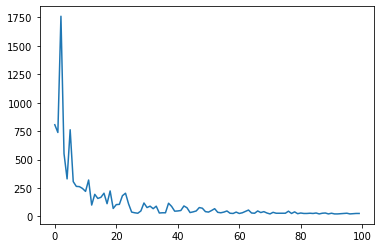

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
max_steps = np.max(steps_per_episode)
print("Maximum steps", max_steps)
min_steps = np.min(steps_per_episode)
print("Minimum steps", min_steps)

plt.plot(range(episodes), steps_per_episode)

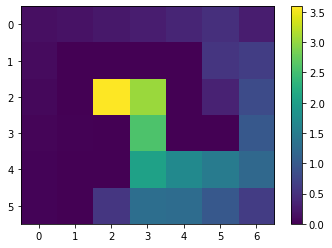

In [50]:
fig, axs = plt.subplots()
im = axs.imshow(V)
fig.colorbar(im)

plt.show()

## Strategy learned

In [43]:
action_encoding = {
    Action.UP: 'U',
    Action.DOWN: 'D',
    Action.LEFT: 'L',
    Action.RIGHT: 'R',
}

def learned_strategy():
    strategy = []
    for row in range(world_height):
        s_row = []
        for col in range(world_width):
            if is_wall(State(row, col)): s_row.append("W")
            else:
                action = next_action(State(row, col))
                s_row.append(action_encoding[action])
        strategy.append(s_row)
    return strategy

learned_strategy()

NameError: name 'next_action' is not defined

In [46]:
# Plot how V changes over learning
# Plot how Policy changes

True